# Introduction

###  Challenge MDI341 2018
#### Authors :  Umut Şimşekli 


The goal of this challenge is to develop a binary classification system which tries to detect if an **image contains moustache or not**.    

As opposed to the previous challenge, we will follow a different procedure in this challenge. The challenge will have **two phases**. Please read the below information carefully.  

**In the first phase** of the challenge, you will be provided a **training dataset** which contains the **raw images** and their corresponding **labels**. We will also provide you a **validation dataset**, which only contains the **raw images**. The labes of the validation set will not be provided. In this phase, you will train your system based on this data and the ranking in the challenge webpage will be based on your score obtained on the validation data.

**The second phase** of the challenge will start only **a couple of hours before the deadline**. Within this period, we will provide you the **test set**. You will need to run the algorithm that you developed on the first phase on this dataset and submit your predictions to the challenge webpage. Your **final ranks** will be determined on this dataset. Note that **this phase will only last a couple of hours**, which means that you will not be able to tune your algorithm on this dataset.



## The properties of the dataset:

**Training data:**

The training set contains raw images and their labels. There are 111430 images in this dataset. Each image is of size 56 x 56 x 3 (the last dimension encodes the color information: red-green-blue). For each image there is a label, either 0 or 1. 0 means there is no moustache in the image, 1 means otherwise.

**Validation data:**

The validation set only contains raw images. There are 10130 images in this dataset, where the image format is the same as before. The labels of this dataset will not be provided. Within the first phase, your ranks will be calculated based on this dataset. 


**Test data:**

The test set only contains raw images as well. There will be 81039 images in this dataset, where the image format is the same as before. The labels of this dataset will not be provided either. This dataset will be provided only in the second phase: only a couple of hours before the challenge deadline. Your final ranks will be calculated based on this dataset. 



### The performance criterion

As you will observe after examining the dataset, the data is highly unbalanced. Therefore, we choose a suitable criterion for evaluation: the performance criterion will be the average accuracy for each class, which is computed as follows: 


$\text{score} = \frac1{2} \Biggl( \frac1{N_0}\sum_{i=1}^{N} (1-y_i)(1-\hat{y}_i) + \frac1{N_1}\sum_{i=1}^{N} y_i \hat{y}_i \Biggr),$

where $N$ denotes the total number elements of the dataset (it could be the training, validation or test set), $N_0$ denotes the number of elements whose labels are $0$, $N_1$ similarly denotes the number of elements whose labels are $1$, $y_i$ denotes the true label of the data sample $i$, and $\hat{y}_i$ denotes the predicted label for the data sample $i$. 


As an example, if all your predictions are 0, then your score will be 50%. The higher the score, the better the performance.



# Training Data

Images: https://www.dropbox.com/s/9le2lpg0v0bq2as/db_train.raw

Labels: https://www.dropbox.com/s/jnqyveug0jz4bsf/label_train.txt


# Validation Data

Images: https://www.dropbox.com/s/xo8qohmfkwtimks/db_val.raw



# Example Submission

An example submission is explained below.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import pydot
import graphviz

## Loading and investigating the data

In [2]:
train_images_fname = 'db_train.raw'
train_labels_fname = 'label_train.txt'

val_images_fname = 'db_val.raw'

# number of images
num_train_images = 111430
num_valid_images = 10130

# size of the images 56*56 pixels in RGB levels
image_dim = 56 * 56 * 3

train_images_label = np.loadtxt(train_labels_fname, dtype=np.float64)

with open(train_images_fname, 'rb') as f:
    train_images_data = np.fromfile(
        f, dtype=np.uint8, count=num_train_images * image_dim).astype(np.float32)
    train_images_data = train_images_data.reshape(num_train_images, image_dim)

with open(val_images_fname, 'rb') as f:
    val_images_data = np.fromfile(
        f, dtype=np.uint8, count=num_valid_images * image_dim).astype(np.float32)
    val_images_data = val_images_data.reshape(num_valid_images, image_dim)

In [3]:
# Investigation
print(train_images_data.shape)
print(train_images_label.shape)
print(val_images_data.shape)

(111430, 9408)
(111430,)
(10130, 9408)


Let's look at some images:

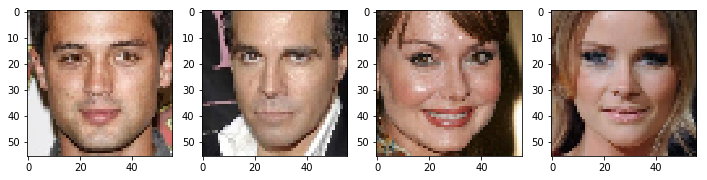

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))

for i, ax in enumerate(axes):
    ax.imshow(train_images_data[i].reshape(56, 56, 3).astype(np.uint8))

## Data Exploration

In [5]:
train_images_data_positive = train_images_data[train_images_label == 1]
train_images_data_positive.shape

(96180, 9408)

---------- Exemples d'images classées positives ----------


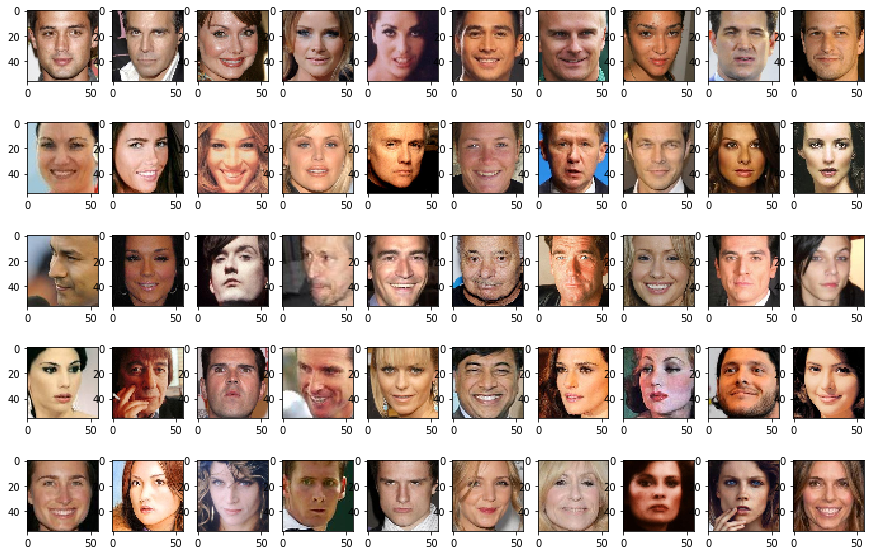

In [6]:
print('---------- Exemples d\'images classées positives ----------')
fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(15, 10))
for i, ax in enumerate(axes):
    for j, im in enumerate(ax):
        im.imshow(
            train_images_data_positive[j + (i * 10)].reshape(56, 56, 3).astype(np.uint8))

In [7]:
train_images_data_negative = train_images_data[train_images_label == 0]
train_images_data_negative.shape

(15250, 9408)

---------- Exemples d'images classées négatives ----------


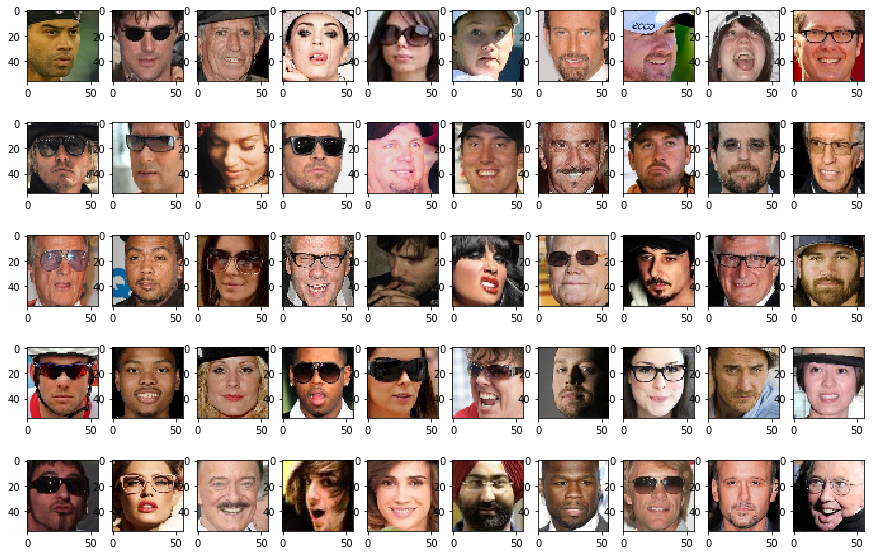

In [8]:
print('---------- Exemples d\'images classées négatives ----------')
fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(15, 10))
for i, ax in enumerate(axes):
    for j, im in enumerate(ax):
        im.imshow(
            train_images_data_negative[j + (i * 10)].reshape(56, 56, 3).astype(np.uint8))

Ce qui semble apparaître de cet examen d'un échantillon d'images, c'est que la problématique ressemble plutôt à une détection d'occlusions (moustache, barbe, lunettes, casquette...) dans le cadre de reconnaissance faciale.

## Deep Learning

In [9]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.utils.np_utils import to_categorical
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
import h5py

/home/ec2-user/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    train_images_data, train_images_label, test_size=0.05, random_state=42)

X_train = X_train.reshape(-1, 56, 56, 3) / 255.
X_test = X_test.reshape(-1, 56, 56, 3) / 255.
y_train = keras.utils.to_categorical(y_train, num_classes=2)
y_test = keras.utils.to_categorical(y_test, num_classes=2)
X_val = val_images_data.reshape(val_images_data.shape[0], 56, 56, 3) / 255.

In [11]:
def createModel():
    model = Sequential()
    model.add(Conv2D(8, (3, 3), padding='same',
                     activation='relu', input_shape=(56, 56, 3)))
    model.add(Conv2D(8, (3, 3), activation='relu'))
    model.add(Dropout(0.25))

    model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    return model

In [25]:
classifier = createModel()
batch_size = 64
epochs = 50
class_weight = {0: 1.525, 1: 9.618}
classifier.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier.summary()
plot_model(classifier, to_file='model_CustomCNN_v2.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 56, 56, 8)         224       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 54, 54, 8)         584       
_________________________________________________________________
dropout_5 (Dropout)          (None, 54, 54, 8)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 54, 54, 16)        1168      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 52, 52, 16)        2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 26, 26, 16)        0         
__________

In [26]:
# this is the augmentation configuration we will use for training
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(X_train)

In [27]:
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model_CustomCNN_v2_with_data_augmentation.h5', monitor='val_loss', save_best_only=True)]

In [28]:
#history = classifier.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, verbose=1, class_weight=class_weight, callbacks=callbacks)
history = classifier.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size, seed=42), validation_data=(X_test, y_test), validation_steps=len(
    X_test) // batch_size, steps_per_epoch=len(X_train) // batch_size, epochs=epochs, verbose=1, class_weight=class_weight, callbacks=callbacks, workers=15, use_multiprocessing=True)

Epoch 1/50
1654/1654 [==============================] - 342s 207ms/step - loss: 1.2713 - acc: 0.8788 - val_loss: 0.2768 - val_acc: 0.9065
Epoch 2/50
1654/1654 [==============================] - 341s 206ms/step - loss: 0.7049 - acc: 0.9027 - val_loss: 0.1874 - val_acc: 0.9307
Epoch 3/50
1654/1654 [==============================] - 341s 206ms/step - loss: 0.6203 - acc: 0.9071 - val_loss: 0.1784 - val_acc: 0.9369
Epoch 4/50
1654/1654 [==============================] - 341s 206ms/step - loss: 0.5505 - acc: 0.9146 - val_loss: 0.2263 - val_acc: 0.9228
Epoch 5/50
1654/1654 [==============================] - 341s 206ms/step - loss: 0.5192 - acc: 0.9171 - val_loss: 0.1818 - val_acc: 0.9380
Epoch 6/50
1654/1654 [==============================] - 340s 206ms/step - loss: 0.5070 - acc: 0.9174 - val_loss: 0.1761 - val_acc: 0.9365
Epoch 7/50
1654/1654 [==============================] - 341s 206ms/step - loss: 0.4904 - acc: 0.9204 - val_loss: 0.1930 - val_acc: 0.9375
Epoch 8/50
1654/1654 [============

In [29]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    # summarize history for accuracy
    axs[0].plot(range(1, len(model_history.history['acc']) + 1),
                model_history.history['acc'])
    axs[0].plot(range(1, len(model_history.history['val_acc']) + 1),
                model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(
        model_history.history['acc']) + 1), len(model_history.history['acc']) / 10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1),
                model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1),
                model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(
        model_history.history['loss']) + 1), len(model_history.history['loss']) / 10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

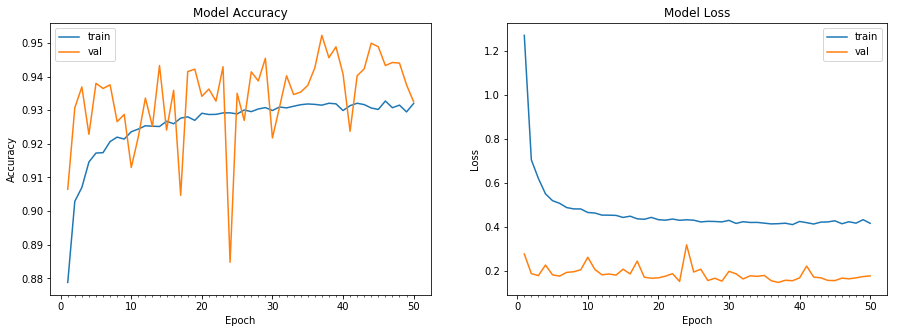

In [30]:
plot_model_history(history)

In [31]:
# Performance measure
def compute_pred_score(y_true, y_pred):
    if(y_true.shape[0] != y_pred.shape[0]):
        raise Exception("y_pred and y_true must have the same size")
    tmp = np.unique(y_pred)
    if(tmp.shape[0] > 2):
        raise("y_pred should only contain 0 and 1")

    if(tmp.shape[0] == 1):
        if(tmp[0] != 0 and tmp[0] != 1):
            raise Exception("y_pred should only contain 0 and 1")
    else:
        if(tmp[0] != 0 and tmp[1] != 1):
            raise Exception("y_pred should only contain 0 and 1")

    y0 = (y_true == 0)
    y1 = (y_true == 1)

    acc1 = np.mean(1 - y_pred[y0])
    acc2 = np.mean(y_pred[y1])

    return (acc1 + acc2) / 2

In [32]:
tmp = classifier.predict(train_images_data.reshape(-1, 56, 56, 3) / 255.)
tmp = np.argmax(tmp, axis=1)
acc_train = compute_pred_score(train_images_label, tmp)
print('The score on the training data : %s' % acc_train)

The score on the training data : 0.7680123504767359


In [33]:
# Generate the prediction
val_pred = classifier.predict(X_val)
val_pred = np.argmax(val_pred, axis=1)
np.savetxt("val_pred_CustomCNN_v2_with_data_augmentation.txt",
           val_pred, fmt="%d")